In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import numpy as np

In [ ]:
mnist_images = load_digits()["data"]
mnist_labels = load_digits()["target"]

In [ ]:
scaler = StandardScaler()
img_scaled = scaler.fit_transform(mnist_images)

In [ ]:
tsne = TSNE(2)
tsne_results = tsne.fit_transform(img_scaled)

In [ ]:
tsne_df = pd.DataFrame()
tsne_df['tsne-2d-one'] = tsne_results[:, 0]
tsne_df['tsne-2d-two'] = tsne_results[:, 1]
tsne_df["y"] = mnist_labels

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [ ]:
kmeans_model = KMeans(10)
kmeans_model.fit(tsne_df[['tsne-2d-one', 'tsne-2d-two']])
clusters_tsne = kmeans_model.predict(tsne_df[['tsne-2d-one', 'tsne-2d-two']])
tsne_df["clusters"] = clusters_tsne

In [ ]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="clusters",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [ ]:
scaler = StandardScaler()
centroids_scaled = scaler.fit_transform(kmeans_model.cluster_centers_)
tsne_scaled = scaler.fit_transform(tsne_df[['tsne-2d-one', 'tsne-2d-two']])
#centroids_scaled = kmeans_model.cluster_centers_

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_49357/4156089413.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sub_tsne[:, 0], sub_tsne[:, 1], 'ko', color=shades_of_blue[i], markersize=2)
/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_49357/4156089413.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(centroids_scaled[i, 0], centroids_scaled[i, 1], 'ko', color="orange")


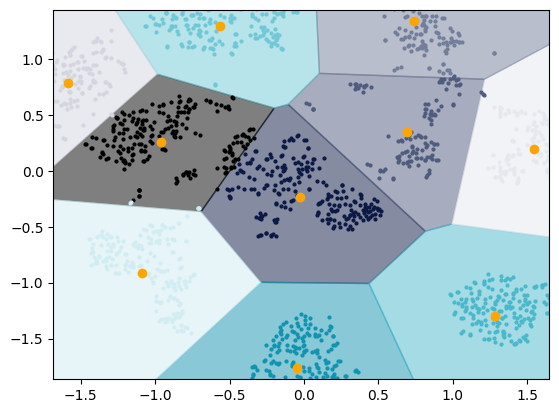

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi


def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


# make up data points
np.random.seed(1234)
points = np.random.rand(15, 2)

# compute Voronoi tesselation
vor = Voronoi(centroids_scaled)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize
shades_of_blue = [
    (12 / 255, 25 / 255, 68 / 255),  # Bleu foncé
    (0, 0, 0),  # blanc,
    (80 / 255, 92 / 255, 126 / 255),  #gris foncé
    (18 / 255, 147 / 255, 176 / 255),
    (74 / 255, 184 / 255, 203 / 255),
    (112 / 255, 200 / 255, 214 / 255),
    (210 / 255, 237 / 255, 242 / 255),
    (231 / 255, 232 / 255, 239 / 255),
    (115 / 255, 126 / 255, 154 / 255),
    (211 / 255, 214 / 255, 224 / 255)

]
for i, region in enumerate(regions):
    sub_tsne = tsne_scaled[tsne_df["clusters"] == i]
    polygon = vertices[region]
    plt.fill(*zip(*polygon), color=shades_of_blue[i], alpha=0.5)
    plt.plot(sub_tsne[:, 0], sub_tsne[:, 1], 'ko', color=shades_of_blue[i], markersize=2)
    plt.plot(centroids_scaled[i, 0], centroids_scaled[i, 1], 'ko', color="orange")

plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('../figures/mnist_voronoi.png')